In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Device 세팅

In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

torch.manual_seed(1)
if device == 'mps':
    torch.mps.manual_seed(1)

print(device)


mps


### 모델 및 학습 정의

In [3]:
DROP_OUT_R = 0.5
LEARNING_RATE = 0.001

EPOCHS = 500
BATCH_SIZE = 50
#VALIDATION_RATE = 0.1

CHECK_INTERVAL = 10
# EARLY_STOP = 30

In [4]:
class CNN_use_V(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(1,2)),
            nn.Dropout(DROP_OUT_R),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=10, out_channels=5, kernel_size=(1,2)),
            nn.Dropout(DROP_OUT_R),
            nn.LeakyReLU()
        )

        self.linear_layer = nn.Sequential(
            nn.Linear(5*1*8,1),
            nn.LeakyReLU()
        )

    def forward(self, input_X):
        X1 = self.conv_layer(input_X)
        X1_flatten = X1.view(X1.shape[0], -1)
        y = self.linear_layer(X1_flatten)
        return y

CNN_10K_5K = CNN_use_V().to(device)

In [5]:
# 파라미터 개수 확인
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(CNN_10K_5K)) #사용

176


In [6]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(CNN_10K_5K.parameters(), lr=LEARNING_RATE)

### 학습 과정 정의

In [7]:
train_losses = []

In [8]:
def train_model(train_loader, epochs, check_interval):
    
    for e in range(epochs):
        train_loss = 0
        
        CNN_10K_5K.train()
        for x_batch, y_batch in train_loader:

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            pred_y = CNN_10K_5K(x_batch)
            loss = loss_func(pred_y, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()    
            
            train_loss += loss.item()

        train_loss = train_loss/len(train_loader)
        train_losses.append(train_loss)
        
        if (e % check_interval) == 0:
            print("epoch : ", e, "train loss: ",train_losses[-1])

### Custom Dataset Type 정의

In [9]:
class BAT_DATASET(Dataset):
    def __init__(self, X, y):
        super().__init__()
        X = deepcopy(X)
        y = deepcopy(y)
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    

    def __getitem__(self, index):
        rX = self.X[index]
        ry = self.y[index]

        return rX, ry
        

### 데이터 묶기 (10개씩)

In [10]:
# 10개의 Voltage_measured로 다음 번째의 Capacity를 예측
# Voltage_measure 10개씩 묶어 준비 n개 준비
# Capacity도 n개 준비

def prepareXY(X_ndArray, y_ndArray):
   X_data = list()

   for idx in range(0,len(X_ndArray), 10):
      X_data.append(X_ndArray[idx: idx+10].T) # Transpose필요, FNN에 10 seq_length를 넣음 (즉, 10 feature처럼)

   X_data = np.array(X_data)

   return X_data, y_ndArray

### ----- ⚠️ 파라미터 불러오기 ------------------------

params = torch.load("../BEST_MODEL/CNN_10K_5K_params.pt")
CNN_10K_5K.load_state_dict(params)

### ----- B0006/B0007/B00018 데이터 학습 ------

In [11]:
def all_data_train_wrapper():
    data_file_indices = ["B0006", "B0007", "B0018"]

    for d_idx in data_file_indices: 
        
        x_df = pd.read_csv(f"../Data/DataFrame/{d_idx}_charge_df.csv").loc[:,["cycle", "voltage_measured", "time"]]
        y_df = pd.read_csv(f"../Data/DataFrame/{d_idx}_capacity_df.csv").loc[:,["capacity"]]

        x_df_10points = pd.DataFrame(columns=x_df.columns)

        for cyc in x_df["cycle"].unique():
            tmp_cycle_x_df = x_df[x_df["cycle"] == cyc]
            interval = len(tmp_cycle_x_df.index)//10
            choosed_idx = []
            for idx in range(0,len(tmp_cycle_x_df), interval):
                if len(choosed_idx) == 10 :
                        break
                choosed_idx.append(idx)

            x_df_10points = pd.concat([x_df_10points, tmp_cycle_x_df.iloc[choosed_idx]], axis=0)

        
        display(x_df_10points)

        X_scaler = MinMaxScaler(feature_range=(0,1))
        y_scaler = MinMaxScaler(feature_range=(0,1))

        RAW_XDATA = deepcopy(x_df_10points)
        RAW_yDATA = deepcopy(y_df)

        X_scaled = X_scaler.fit_transform(RAW_XDATA["voltage_measured"].values.reshape(-1,1))
        y_scaled = y_scaler.fit_transform(RAW_yDATA["capacity"].unique().reshape(-1,1))

        X_data, y_data= prepareXY(X_scaled, y_scaled)
        X_data = torch.from_numpy(X_data).type(torch.float).reshape(X_data.shape[0],1,1,10)
        y_data = torch.from_numpy(y_data).type(torch.float)

        train_dataset = BAT_DATASET(X_data, y_data)

        train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=False)

        train_model(train_loader, EPOCHS, CHECK_INTERVAL)

In [12]:
all_data_train_wrapper()

,cycle,voltage_measured,time
0,2,3.320249,5.500
76,2,3.772765,234.078
152,2,3.869867,511.156
228,2,3.928052,875.062
304,2,3.968767,1364.266
...,...,...,...
375596,169,4.198806,3460.406
375852,169,4.199172,4206.797
376108,169,4.199734,4952.406
376364,169,4.199159,5697.531


epoch :  0 train loss:  0.17780380323529243
epoch :  10 train loss:  0.1364814443513751
epoch :  20 train loss:  0.11930565536022186
epoch :  30 train loss:  0.10002427361905575
epoch :  40 train loss:  0.10287055093795061
epoch :  50 train loss:  0.08902039378881454
epoch :  60 train loss:  0.09330383641645312
epoch :  70 train loss:  0.09378314297646284
epoch :  80 train loss:  0.08893284387886524
epoch :  90 train loss:  0.0939316963776946
epoch :  100 train loss:  0.08202326530590653
epoch :  110 train loss:  0.0835698670707643
epoch :  120 train loss:  0.09229979803785682
epoch :  130 train loss:  0.08958259969949722
epoch :  140 train loss:  0.08325873035937548
epoch :  150 train loss:  0.08555219136178493
epoch :  160 train loss:  0.08406637283042073
epoch :  170 train loss:  0.08004424767568707
epoch :  180 train loss:  0.07748568803071976
epoch :  190 train loss:  0.08387031545862556
epoch :  200 train loss:  0.07167871645651758
epoch :  210 train loss:  0.08468690421432257
ep

,cycle,voltage_measured,time
0,2,3.270404,5.500
76,2,3.785553,234.078
152,2,3.881019,511.156
228,2,3.937696,875.062
304,2,3.978918,1364.266
...,...,...,...
375596,169,4.211561,3460.406
375852,169,4.212398,4206.797
376108,169,4.213197,4952.406
376364,169,4.211974,5697.531


epoch :  0 train loss:  0.06656479043886065
epoch :  10 train loss:  0.06710830796509981
epoch :  20 train loss:  0.06542416149750352
epoch :  30 train loss:  0.06461001606658101
epoch :  40 train loss:  0.06238008104264736
epoch :  50 train loss:  0.061653952579945326
epoch :  60 train loss:  0.06637901905924082
epoch :  70 train loss:  0.05847726436331868
epoch :  80 train loss:  0.06666195392608643
epoch :  90 train loss:  0.05803479440510273
epoch :  100 train loss:  0.0681805070489645
epoch :  110 train loss:  0.062328262720257044
epoch :  120 train loss:  0.06214023940265179
epoch :  130 train loss:  0.04572735307738185
epoch :  140 train loss:  0.0491031757555902
epoch :  150 train loss:  0.05395425437018275
epoch :  160 train loss:  0.04721128148958087
epoch :  170 train loss:  0.04297572001814842
epoch :  180 train loss:  0.043750991113483906
epoch :  190 train loss:  0.04737922362983227
epoch :  200 train loss:  0.04748358204960823
epoch :  210 train loss:  0.0365825043991208

,cycle,voltage_measured,time
0,2,3.479525,5.219
257,2,3.938450,653.547
514,2,3.997673,1303.219
771,2,4.049742,1952.907
1028,2,4.124331,2602.360
...,...,...,...
190602,134,4.198443,3527.000
190702,134,4.198810,4252.766
190802,134,4.200036,4977.859
190902,134,4.199606,5706.000


epoch :  0 train loss:  0.05319776820639769
epoch :  10 train loss:  0.04134977360566457
epoch :  20 train loss:  0.04505732282996178
epoch :  30 train loss:  0.038919722040494285
epoch :  40 train loss:  0.0387952650586764
epoch :  50 train loss:  0.039368816961844764
epoch :  60 train loss:  0.03586019389331341
epoch :  70 train loss:  0.03666370237867037
epoch :  80 train loss:  0.03703602962195873
epoch :  90 train loss:  0.035030181830128036
epoch :  100 train loss:  0.03473136325677236
epoch :  110 train loss:  0.034670776377121605
epoch :  120 train loss:  0.03618973679840565
epoch :  130 train loss:  0.030584746971726418
epoch :  140 train loss:  0.04030519103010496
epoch :  150 train loss:  0.028245297260582447
epoch :  160 train loss:  0.03419574722647667
epoch :  170 train loss:  0.03607836924493313
epoch :  180 train loss:  0.03761241522928079
epoch :  190 train loss:  0.04014179607232412
epoch :  200 train loss:  0.03308875237902006
epoch :  210 train loss:  0.030938147256

### ----- ⚠️ 새로운 파라미터 저장 ------------------------

CNN_10K_5K_params = CNN_10K_5K.state_dict()
torch.save(CNN_10K_5K_params, "../BEST_MODEL/CNN_10K_5K_params.pt")

### B0005 예측

In [13]:
x_df = pd.read_csv(f"../Data/DataFrame/B0005_charge_df.csv").loc[:,["cycle", "voltage_measured", "time"]]
y_df = pd.read_csv(f"../Data/DataFrame/B0005_capacity_df.csv").loc[:,["capacity"]]

x_df_10points = pd.DataFrame(columns=x_df.columns)
for cyc in x_df["cycle"].unique():
    tmp_cycle_x_df = x_df[x_df["cycle"] == cyc]
    interval = len(tmp_cycle_x_df.index)//10
    choosed_idx = []
    for idx in range(0,len(tmp_cycle_x_df), interval):
        if len(choosed_idx) == 10 :
            break
        choosed_idx.append(idx)

    x_df_10points = pd.concat([x_df_10points, tmp_cycle_x_df.iloc[choosed_idx]], axis=0)    
display(x_df_10points)

X_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

RAW_XDATA = deepcopy(x_df_10points)
RAW_yDATA = deepcopy(y_df)

X_scaled = X_scaler.fit_transform(RAW_XDATA["voltage_measured"].values.reshape(-1,1))
y_scaled = y_scaler.fit_transform(RAW_yDATA["capacity"].unique().reshape(-1,1))
        
X_data, y_data= prepareXY(X_scaled, y_scaled)
X_data = torch.from_numpy(X_data).type(torch.float).reshape(X_data.shape[0],1,1,10)
y_data = torch.from_numpy(y_data).type(torch.float)

test_dataset = BAT_DATASET(X_data, y_data)

test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False)

predicts = []

CNN_10K_5K.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
            
        pred_y = CNN_10K_5K(x_batch)

        predicts.append(pred_y.to('cpu'))

predicts_concat = torch.cat(predicts, 0)
predicts_df = pd.DataFrame(y_scaler.inverse_transform(np.array(predicts_concat)))


,cycle,voltage_measured,time
0,2,3.434644,5.500
76,2,3.814079,234.078
152,2,3.881686,511.156
228,2,3.937241,875.062
304,2,3.979605,1364.266
...,...,...,...
375596,169,4.205285,3460.406
375852,169,4.205106,4206.797
376108,169,4.204985,4952.406
376364,169,4.206357,5697.531


In [14]:
predicts_df

,0
0,1.992685
1,1.992897
2,1.989275
3,1.992392
4,1.994485
...,...
162,1.307200
163,1.303088
164,1.300036
165,1.298547


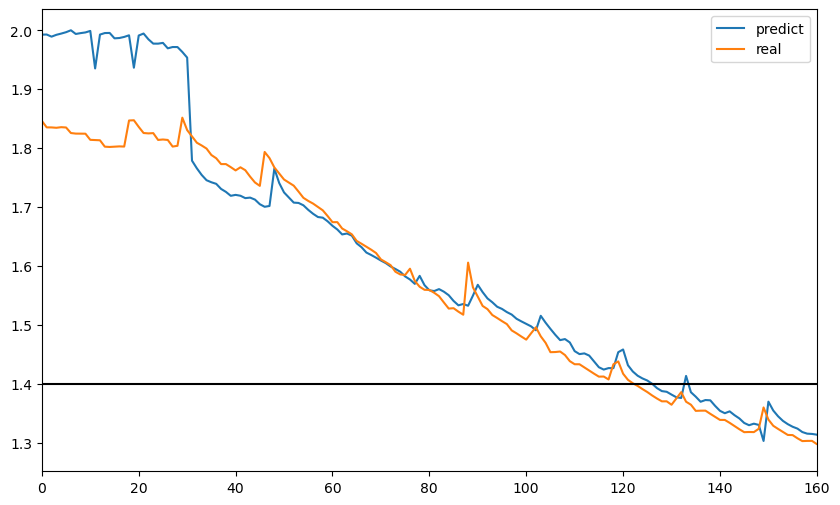

In [15]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 6]
plt.xlim([0, 160])

plt.plot(predicts_df.index, predicts_df.iloc[:,0], label='predict')
plt.plot(range(len(y_df.index)), y_df.iloc[:,0], label='real')
plt.plot(range(len(y_df.index)), [1.4 for i in range(len(y_df.index))], color='black')

plt.legend()
plt.show()

predicts_df.to_csv("../PREDICT/CNN_10K_5K.csv", index = False)